<a href="https://colab.research.google.com/github/mrch-hub/bangkit1/blob/test_feature_1/SolarPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Solar radiation intensity prediction using TensorFlow

In [40]:
"""A python code for predicting solar radiation
intensity using TensorFlow. Created for 
5th Bangk!t assignment.
Collaborators: Marcellinus Chrisnada, Muhammad
Harits Hafidza, Mochammad Randy Caesario H."""

'A python code for predicting solar radiation\nintensity using TensorFlow. Created for \n5th Bangk!t assignment.\nCollaborators: Marcellinus Chrisnada, Muhammad\nHarits Hafidza, Mochammad Randy Caesario H.'

##Initialization

In [0]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

In [42]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

# Adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


In [43]:
#@title Load dataset
data = pd.read_csv('https://raw.githubusercontent.com/mrch-hub/bangkit1/master/SolarPrediction.csv')
data = data.reindex(np.random.permutation(data.index)) # shuffle dataset
data.head(40)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
3082,1474283402,9/19/2016 12:00:00 AM,01:10:02,1.2,48,30.4,47,191.1,7.9,06:11:00,18:22:00
23742,1478229024,11/3/2016 12:00:00 AM,17:10:24,80.0,61,30.4,50,27.2,6.8,06:25:00,17:47:00
22986,1478456402,11/6/2016 12:00:00 AM,08:20:02,455.5,60,30.5,18,35.8,9.0,06:26:00,17:46:00
3302,1474213203,9/18/2016 12:00:00 AM,05:40:03,1.2,50,30.4,100,179.1,3.4,06:11:00,18:23:00
17075,1480231217,11/26/2016 12:00:00 AM,21:20:17,1.2,45,30.5,81,95.7,3.4,06:38:00,17:42:00
...,...,...,...,...,...,...,...,...,...,...,...
13696,1476093625,10/10/2016 12:00:00 AM,00:00:25,1.3,49,30.4,87,178.3,6.8,06:16:00,18:03:00
23895,1478183118,11/3/2016 12:00:00 AM,04:25:18,1.2,45,30.4,38,185.8,6.8,06:25:00,17:47:00
5692,1473264623,9/7/2016 12:00:00 AM,06:10:23,8.1,45,30.4,78,164.1,3.4,06:08:00,18:33:00
30584,1481441761,12/10/2016 12:00:00 AM,21:36:01,1.3,48,30.4,102,85.4,2.2,06:47:00,17:44:00


##Adding some features to the dataset

In [0]:
#@title Adding feature is_daylight that define measurement time is either daylight (1) or nighttime (0)
is_daylight = [data['Time'].values[x] > data['TimeSunRise'].values[x] and data['Time'].values[x] < data['TimeSunSet'].values[x] for x in range(len(data))]
data['is_daylight'] = is_daylight
data['is_daylight'] = data['is_daylight'].astype('float')

##Data Preconditioning

In [45]:
#@title Splitting data to train set and test set
test_split = 0.2 # percentage of train set to be considered as test set
data_test = data[:][0:round((len(data)*test_split))]
data_train = data[:][round((len(data)*test_split)):]
print('train set length:', str(len(data_train)), '\ntest set length:', 
      str(len(data_test)))

train set length: 26149 
test set length: 6537


In [46]:
#@title Normalize values 

# Calculate the Z-scores of each column in the training set:
data_train_mean = data_train.select_dtypes(include=['float64', 'int64']).mean()
data_train_std = data_train.select_dtypes(include=['float64', 'int64']).std()
data_train_norm = (data_train.select_dtypes(include=['float64', 'int64']) 
                   - data_train_mean)/data_train_std

# Calculate the Z-scores of each column in the test set.
data_test_mean = data_test.select_dtypes(include=['float64', 'int64']).mean()
data_test_std = data_test.select_dtypes(include=['float64', 'int64']).std()
data_test_norm = (data_test.select_dtypes(include=['float64', 'int64'])
                  - data_test_mean)/data_test_std

print("Normalized the values.")

Normalized the values.


## Represent data

The following code cell creates a feature layer containing three features:

* `Temperature`
* `Pressure`
* `is_daylight`

In [0]:
# Create empty feature column list
feature_columns = []

# Represent Temperature as a floating-point value.
temperature = tf.feature_column.numeric_column("Temperature")
feature_columns.append(temperature)

# Represent Pressure as a floating-point value.
pressure = tf.feature_column.numeric_column("Pressure")
feature_columns.append(pressure)

# Represent is_daylight as a floating-point value.
daylight = tf.feature_column.numeric_column("is_daylight")
feature_columns.append(daylight)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

## Build a linear regression model

In [48]:
#@title Define plotting function

def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [49]:
#@title Define functions to create and train a linear regression model
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model           


def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["mean_squared_error"]

  return epochs, rmse   

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


Epoch 1/50
27/27 [==============================] - 0s 2ms/step - loss: 0.5094 - mean_squared_error: 0.5142
Epoch 2/50
27/27 [==============================] - 0s 2ms/step - loss: 0.4113 - mean_squared_error: 0.4130
Epoch 3/50
27/27 [==============================] - 0s 2ms/step - loss: 0.3792 - mean_squared_error: 0.3790
Epoch 4/50
27/27 [==============================] - 0s 2ms/step - loss: 0.3760 - mean_squared_error: 0.3739
Epoch 5/50
27/27 [==============================] - 0s 2ms/step - loss: 0.3760 - mean_squared_error: 0.3739
Epoch 6/50
27/27 [==============================] - 0s 2ms/step - loss: 0.3721 - mean_squared_error: 0.3738
Epoch 7/50
27/27 [==============================] - 0s 2ms/step - loss: 0.3736 - mean_squared_error: 0.3736
Epoch 8/50
27/27 [==============================] - 0s 2ms/step - loss: 0.3735 - mean_squared_error: 0.3739
Epoch 9/50
27/27 [==============================] - 0s 2ms/step - loss: 0.3732 - mean_squared_error: 0.3735
Epoch 10/50
27/27 [=========

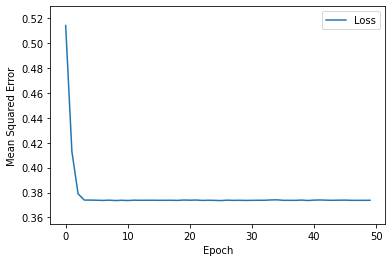


 Evaluate the linear regression model against the test set:
7/7 [==============================] - 0s 2ms/step - loss: 0.3697 - mean_squared_error: 0.3698


[0.36969563364982605, 0.36979421973228455]

In [52]:
#@title Train the model as linear regression
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 50
batch_size = 1000
label_name = "Radiation"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, data_train_norm, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in data_test_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)